In [35]:
import numpy as np
import pandas as pd
import tools as tls
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
def total_housing_loan(house_price, monthly_payment, annual_interest_rate, annual_rise, years):
    """
    Calculate the total amount of money spent to buy a house with loan of interest rate.
    """
    _, total_interest = tls.loan(house_price, monthly_payment, annual_interest_rate, years)
    spent_total = house_price + total_interest
    current_value = house_price * (1 + annual_rise) ** years
    return spent_total, current_value 

def renting(house_price, surface_profit, years):
    """
    Calculate the total amount of money spent to rent a house.
    """
    monthly_rent = house_price * surface_profit / 12
    total_rent = monthly_rent * years * 12
    return total_rent

def unrealized_profit(house_price,surface_profit,years,SP500 = 0.07, annual_interest_rate=0.03):
    """
    Calculate the unrealized profit by buying a house.
    """
    monthly_rent = house_price * surface_profit / 12
    monthly_payment = house_price/years/12
    monthly_SP500 = monthly_payment - monthly_rent
    total_profit = 0
    interest = 0 
    for i in range(years):
        interest = (house_price - monthly_payment*12*i)*annual_interest_rate
        total_profit += (monthly_SP500*12+interest) * (1 + SP500) ** (years-i)
    #total_profit -= 12*monthly_SP500*years
    return total_profit
    

In [37]:
house_price = np.linspace(3000,15000,100)
years = 20 #15 years of loan
monthly_payment = house_price/years/12
annual_interest_rate = 0.03
annual_rise = np.linspace(-0.02,0.02,100)
surface_profit = 0.04
monthly_rent = house_price * surface_profit / 12

df = pd.DataFrame({
    'house_price': house_price,
    'monthly_payment': monthly_payment,
    'annual_interest_rate': annual_interest_rate,
    'annual_rise': annual_rise,
    'surface_profit': surface_profit,
    'monthly_rent': monthly_rent
})


In [38]:
def calculate_profit_diff(row):
    spent, value = total_housing_loan(row['house_price'], row['monthly_payment'], row['annual_interest_rate'], row['annual_rise'], years)
    rent_cost = renting(row['house_price'], row['surface_profit'], years)
    total_profit = unrealized_profit(row['house_price'], row['surface_profit'], years)
    return value - total_profit

df['buy_vs_rent_profit'] = df.apply(calculate_profit_diff, axis=1)
df.head()

,house_price,monthly_payment,annual_interest_rate,annual_rise,surface_profit,monthly_rent,buy_vs_rent_profit
0,3000.000000,12.500000,0.03,-0.020000,0.04,10.000000,-1816.807363
1,3121.212121,13.005051,0.03,-0.019596,0.04,10.404040,-1872.964265
2,3242.424242,13.510101,0.03,-0.019192,0.04,10.808081,-1927.640541
3,3363.636364,14.015152,0.03,-0.018788,0.04,11.212121,-1980.819304
4,3484.848485,14.520202,0.03,-0.018384,0.04,11.616162,-2032.483506


In [39]:
df['buy_vs_rent_profit'].describe()

count     100.000000
mean    -1397.236316
std      1652.984521
min     -2789.463258
25%     -2619.826981
50%     -2139.103859
75%      -635.938757
max      3191.054550
Name: buy_vs_rent_profit, dtype: float64

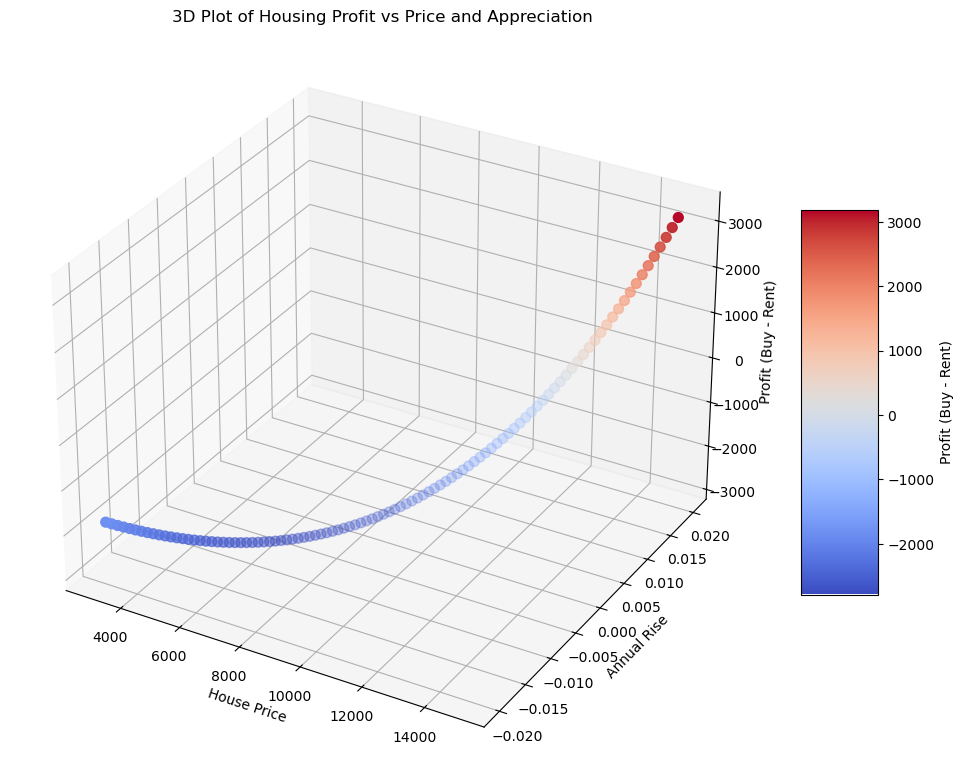

In [40]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Since house_price and annual_rise are coupled 1-to-1 in the dataframe,
# we use a scatter plot to visualize the specific scenarios.
x = df['house_price']
y = df['annual_rise']
z = df['buy_vs_rent_profit']

# Plot the points
scatter = ax.scatter(x, y, z, c=z, cmap='coolwarm', s=50)

# Add a color bar which maps values to colors
fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='Profit (Buy - Rent)')

ax.set_xlabel('House Price')
ax.set_ylabel('Annual Rise')
ax.set_zlabel('Profit (Buy - Rent)')
ax.set_title('3D Plot of Housing Profit vs Price and Appreciation')

plt.show()